## 3.1

In [1]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as sfft
import matplotlib.mlab as mlab
import scipy.signal as ss
import cis


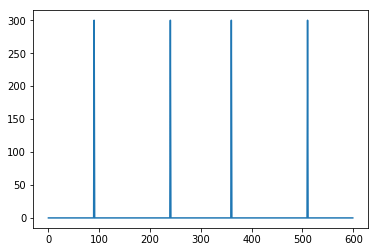

In [2]:
fs = 100
t = np.arange(0, 7, 1 / fs)
y = np.sin(2 * np.pi * 15 * t) + np.cos(2 * np.pi * 40 * t)  # f=15, 40 の周波数を足し合わせ
cs = sfft.fft(y[:600])
plt.plot(np.abs(cs))


In [3]:
print(cs.shape)
# スペクトルのある周波数成分を取り出す
o = (np.abs(cs) > 250).nonzero()
print(o)


(600,)
(array([ 90, 240, 360, 510]),)


### 上のサンプルの情報

+ サンプリング周波数(Fs): 100 [Hz]
+ サンプリング点数: 600
+ ナイキスト周波数: 50 (2/Fs) [Hz]

### memo
DFTでは, 周波数領域では, Fsが１周期となる. 600点サンプリングしてるので, 周波数領域の間隔は 

$$
100/600 = 1/6 [Hz]
$$

となる.

よって, $i=90$ は $90*1/6 = 15[Hz]$ を表す. 同様に $i=240$ は $40[Hz]$ を表す.


### 位相の導出 


In [4]:
print(cs[90])
print(cs[240])

# np.angleで位相を算出(ラジアンに180/pi かけた)
print(np.angle(cs[np.array([90,240])])/np.pi*180)

(-7.972289495228324e-12-300.0000000000002j)
(300.0000000000008-6.551204023708124e-12j)
[-9.0000000e+01 -1.2511878e-12]


## p 37のメモ

位相は, $tan^{-1}(虚部/実部)$ でも求められる. 電気回路でやってたのと同じやつ.

In [5]:
# tan^{-1}で算出(符号は...)
print(np.arctan(cs[90].imag/cs[90].real)/np.pi*180)

89.99999999999848


## 3.2 窓関数

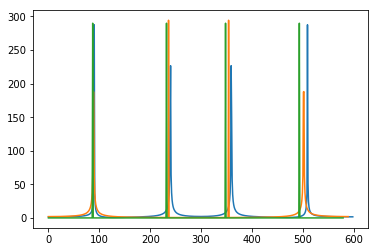

In [6]:
plt.plot(np.abs(sfft.fft(y[0:599])))
plt.plot(np.abs(sfft.fft(y[0:590])))
plt.plot(np.abs(sfft.fft(y[0:580])))

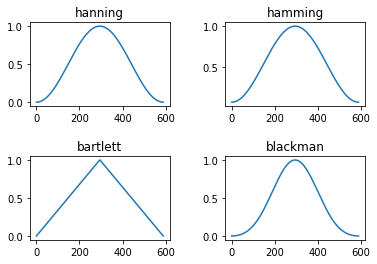

In [7]:
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.6)  # グラフ間距離設定

axes[0, 0].set_title('hanning')
axes[0, 0].plot(np.hanning(590), )
axes[0, 1].set_title('hamming')
axes[0, 1].plot(np.hamming(590))
axes[1, 0].set_title('bartlett')
axes[1, 0].plot(np.bartlett(590))
axes[1, 1].set_title('blackman')
axes[1, 1].plot(np.blackman(590))

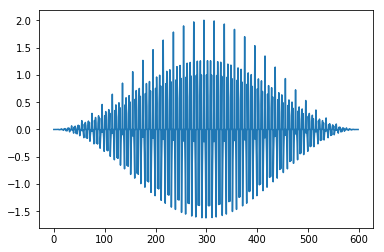

In [8]:
hy = y[:599]*np.hanning(599)
plt.plot(hy)

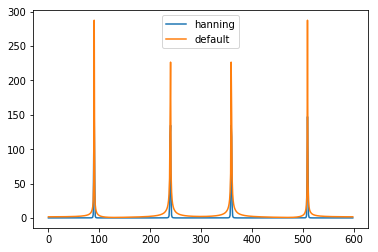

In [9]:
plt.plot(np.abs(sfft.fft(hy)), label='hanning')
plt.plot(np.abs(sfft.fft(y[:599])), label='default')
plt.legend() # 凡例の表示
plt.show()

hanning窓によって切り出しの影響が小さく(ふもと部分の広がりが小さく)なってることが確認できる

## 3.3

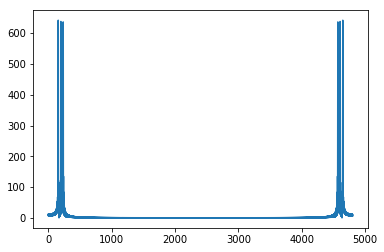

In [10]:
y, fs = cis.wavread('/root/book_files/audio/domiso.wav')

plt.plot(np.abs(sfft.fft(y)))
plt.show()

cis.audioplay(y, fs)

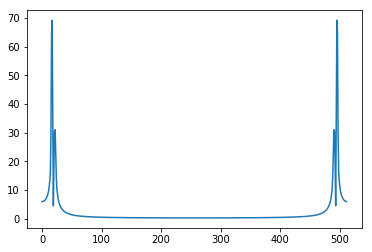

In [11]:
plt.plot(np.abs(sfft.fft(y[1300:1812]*np.hanning(512))))
plt.show()

## specgram

スペクトログラムって読む？

信号データを少しずつ区分に分割し, まとめてFFT処理する.


(256, 36)


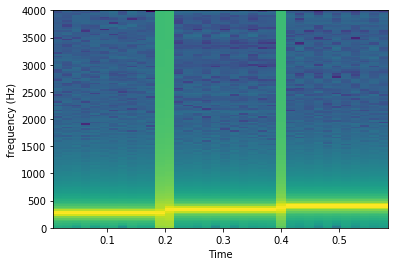

In [13]:
S,F,T = mlab.specgram(y, Fs=fs,NFFT=256, window=np.hanning(256),
                     noverlap=128,mode='complex',sides='twosided')
print(S.shape)


# pyplotの関数
plt.specgram(y, Fs=fs,NFFT=256, window=np.hanning(256), noverlap=128)
plt.xlabel('Time')
plt.ylabel('frequency (Hz)')
plt.show()

上のグラフだと0.2, 0.4秒のところで音が切り替わってる.(ド, レ, ミ)

そこに縦に帯みたいに伸びてるのは窓関数による切り取りの影響？

## memo
NFFT: FFTの長さ(点数)
window: 窓関数

この2つは同じ長さにする必要がある.

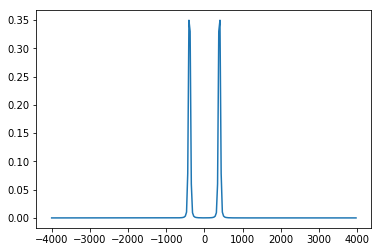

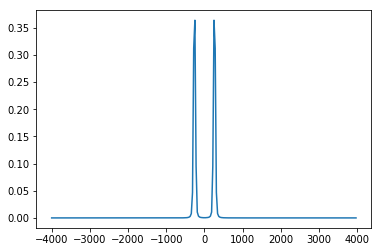

In [14]:
plt.plot(F,np.abs(S[:,35]))
plt.show()
plt.plot(F,np.abs(S[:,0]))
plt.show()

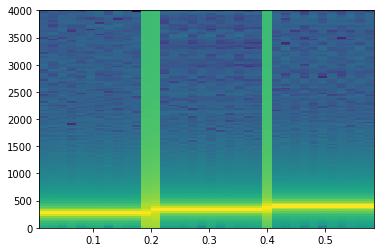

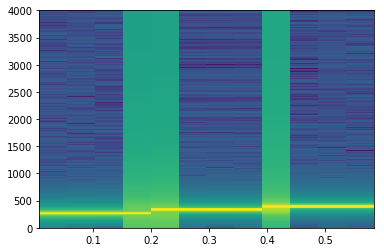

In [15]:
plt.figure(1);
plt.specgram(y, Fs=fs,NFFT=256, window=np.hanning(256), noverlap=128)
plt.show()

plt.figure(2);
plt.specgram(y, Fs=fs,NFFT=512, window=np.hanning(512), noverlap=128)
plt.show()

FFTの長さが長い後者は, 周波数帯がはっきりしている. 音の接続部のにじみ幅(縦の帯)が広くなる.

周波数帯がはっきりしている: 周波数の解像度が高い

音の接続部のにじみ幅(縦の帯)が広い: 時間の解像度が低い


## 逆フーリエ

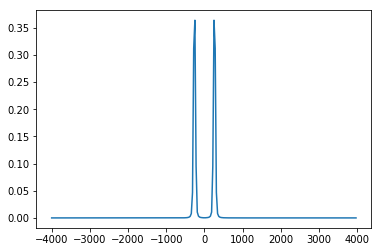

In [17]:

S09 = S[:,9] # "行をとりだしとなってるが" 10列目のFFT結果
plt.plot(F,np.abs(S09))
plt.show()

specgramの結果は真ん中が直流成分となっている.

`ifft`で逆フーリエ変換するが, このメソッドは端が直流成分であることを想定しているので, `fftshift`でshiftしてやる必要がある.

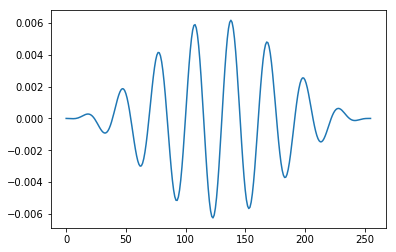

In [18]:
plt.plot(np.real(sfft.ifft(sfft.fftshift(S09))))

すべてのフレームのifftを足し合わせ, もとの時間波形を復元する.

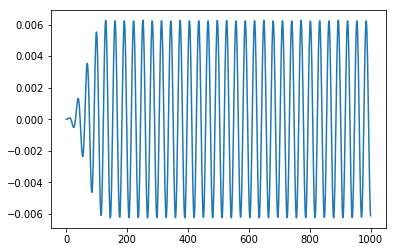

In [19]:
y, fs = cis.wavread('/root/book_files/audio/domiso.wav')
fftlen = 256 # FFTの点数
noverlap = 128 # フレームごとに重なる点数
S,_,_ = mlab.specgram(y, Fs=fs, NFFT=fftlen, window=np.hanning(fftlen), noverlap=noverlap, mode='complex', sides='twosided' )

slen = S.shape[1] # フレーム数
S = sfft.fftshift(S, axes=0) # まとめてsift
ry = np.zeros(slen*fftlen-(slen-1)*noverlap)
k1 = 0
for k in range(0, slen):
    ry[k1:k1+fftlen] = ry[k1:k1+fftlen]+np.real(sfft.ifft(S[:,k])) # オーバーラップ分は重ねる
    k1=k1+noverlap

plt.plot(ry[:1000])
plt.show()

In [20]:
cis.audioplay(y, fs)
cis.audioplay(ry, fs)

もとの音声とほとんど同じものが復元できている.